# Airflights (SQL)   

### PROJECT

## Цель:    
Используя SQL-запросы и средства аналитики, доступные в Python, проанализировать данные авиакомпании и оптимизировать зимние авиарейсы. 

- При помощи сложного SQL-запроса был составлен комплексный датасет с агрегированной информацией о рейсах из г.Анапы в зимнее время.  
- Датасет с агрегированной информацией (файл - flights_df.csv) проанализирован в данном ноутбуке средствами аналитики и визуализации на языке Python.
- По результатам работы представлены выводы о самых малоприбыльных авиарейсах (в формате презентации, файл - AirFlights_Presentation.pptx). 

## Структура  
1. Импорт и вспомогательные функции  
2. Первичный осмотр данных  
3. Анализ данных

# 1. Импорт и вспомогательные функции 

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import itertools

%matplotlib inline
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', 100)  # показывать больше колонок

#### Вспомогательные функции

In [2]:
def get_boxplot(DF, column, parameter):
    # Быстрое построение боксплотов
    fig, ax = plt.subplots(figsize = (6, 6))
    sns.boxplot(
                x = column,  y = parameter,
                data = DF.loc[DF.loc[:, column].isin(DF.loc[:, column].value_counts().index[:20])],
                ax = ax, flierprops = {"marker": "x"}, medianprops = {"color": "coral"}, showfliers = True, notch = True
                 )
    plt.xticks(rotation = 90)
    ax.set_title('Boxplot for ' + column)
    plt.grid()
    plt.show()

In [3]:
def outliers_iqr(ys):
    # Нахождение выбросов. Формула межквартильного расстояния 
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])   # vis_data.distance.quantile([0.25, 0.75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - iqr*1.5
    upper_bound = quartile_3 + iqr*1.5
    print(f'25-й перцентиль: {quartile_1}, \n75-й перцентиль: {quartile_3}, \nIQR: {iqr}, \nГраницы выбросов: [{lower_bound}, {upper_bound}].')
    return (lower_bound, upper_bound)

# 2. Первичный осмотр данных

- Загрузка данных, выведение информации о колонках и статистической информации  
- Проверка данных на корректность и валидность  
- Просмотр уникальных значений

In [5]:
# Загрузим датасет посмотрим на данные
flights_df = pd.read_csv('flights_df.csv')
display(flights_df)
display(flights_df.info())
print(f'Размер датасета: {flights_df.shape}\n')

,flight_id,flight_no,departure_city,departure_airport,arrival_city,arrival_airport,departure_airport_longitude,departure_airport_latitude,arrival_airport_longitude,arrival_airport_latitude,status,scheduled_departure,scheduled_arrival,actual_departure,actual_arrival,scheduled_flight_duration,actual_flight_duration,aircraft_code,aircraft_model,fuel_consumption_per_minute,fuel_cost,all_seats_total_cnt,sold_tickets_total_cnt,economy_seats_cnt,sold_economy_tickets_cnt,business_seats_cnt,sold_business_tickets_cnt,total_tickets_revenue,economy_tickets_revenue,business_tickets_revenue
0,136119,PG0252,Anapa,AAQ,Moscow,SVO,37.35,45.00,37.41,55.97,Arrived,2017-01-03T10:05:00Z,2017-01-03T11:45:00Z,2017-01-03T10:08:00Z,2017-01-03T11:49:00Z,100.00,101.00,733,Boeing 737-300,40.00,41.44,130,113.00,118,102.00,12,11.00,1653000.00,1250400.00,402600.00
1,136120,PG0252,Anapa,AAQ,Moscow,SVO,37.35,45.00,37.41,55.97,Arrived,2017-02-24T10:05:00Z,2017-02-24T11:45:00Z,2017-02-24T10:07:00Z,2017-02-24T11:46:00Z,100.00,99.00,733,Boeing 737-300,40.00,39.55,130,109.00,118,98.00,12,11.00,1605400.00,1202800.00,402600.00
2,136122,PG0252,Anapa,AAQ,Moscow,SVO,37.35,45.00,37.41,55.97,Arrived,2017-01-08T10:05:00Z,2017-01-08T11:45:00Z,2017-01-08T10:08:00Z,2017-01-08T11:48:00Z,100.00,100.00,733,Boeing 737-300,40.00,41.44,130,97.00,118,87.00,12,10.00,1431000.00,1065000.00,366000.00
3,136130,PG0252,Anapa,AAQ,Moscow,SVO,37.35,45.00,37.41,55.97,Arrived,2017-02-13T10:05:00Z,2017-02-13T11:45:00Z,2017-02-13T10:07:00Z,2017-02-13T11:46:00Z,100.00,99.00,733,Boeing 737-300,40.00,39.55,130,107.00,118,97.00,12,10.00,1556600.00,1190600.00,366000.00
4,136131,PG0252,Anapa,AAQ,Moscow,SVO,37.35,45.00,37.41,55.97,Arrived,2017-01-28T10:05:00Z,2017-01-28T11:45:00Z,2017-01-28T10:07:00Z,2017-01-28T11:46:00Z,100.00,99.00,733,Boeing 737-300,40.00,41.44,130,124.00,118,112.00,12,12.00,1812800.00,1373600.00,439200.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,136943,PG0480,Anapa,AAQ,Belgorod,EGO,37.35,45.00,36.59,50.64,Arrived,2016-12-05T09:25:00Z,2016-12-05T10:15:00Z,2016-12-05T09:28:00Z,2016-12-05T10:18:00Z,50.00,50.00,SU9,Sukhoi Superjet-100,28.33,38.87,97,94.00,85,83.00,12,11.00,733800.00,525900.00,207900.00
189,136951,PG0480,Anapa,AAQ,Belgorod,EGO,37.35,45.00,36.59,50.64,Arrived,2017-02-02T09:25:00Z,2017-02-02T10:15:00Z,2017-02-02T09:28:00Z,2017-02-02T10:17:00Z,50.00,49.00,SU9,Sukhoi Superjet-100,28.33,39.55,97,90.00,85,78.00,12,12.00,720600.00,493800.00,226800.00
190,136953,PG0480,Anapa,AAQ,Belgorod,EGO,37.35,45.00,36.59,50.64,Arrived,2017-02-27T09:25:00Z,2017-02-27T10:15:00Z,2017-02-27T09:27:00Z,2017-02-27T10:17:00Z,50.00,50.00,SU9,Sukhoi Superjet-100,28.33,39.55,97,97.00,85,85.00,12,12.00,765300.00,538500.00,226800.00
191,136956,PG0480,Anapa,AAQ,Belgorod,EGO,37.35,45.00,36.59,50.64,Arrived,2017-02-04T09:25:00Z,2017-02-04T10:15:00Z,2017-02-04T09:33:00Z,2017-02-04T10:23:00Z,50.00,50.00,SU9,Sukhoi Superjet-100,28.33,39.55,97,96.00,85,85.00,12,11.00,746400.00,538500.00,207900.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   flight_id                    193 non-null    int64  
 1   flight_no                    193 non-null    object 
 2   departure_city               193 non-null    object 
 3   departure_airport            193 non-null    object 
 4   arrival_city                 193 non-null    object 
 5   arrival_airport              193 non-null    object 
 6   departure_airport_longitude  193 non-null    float64
 7   departure_airport_latitude   193 non-null    float64
 8   arrival_airport_longitude    193 non-null    float64
 9   arrival_airport_latitude     193 non-null    float64
 10  status                       193 non-null    object 
 11  scheduled_departure          193 non-null    object 
 12  scheduled_arrival            193 non-null    object 
 13  actual_departure    

None

Размер датасета: (193, 30)



In [6]:
# Статистическая информация
display(flights_df.describe())
flights_df.describe(include = 'object')

,flight_id,departure_airport_longitude,departure_airport_latitude,arrival_airport_longitude,arrival_airport_latitude,scheduled_flight_duration,actual_flight_duration,fuel_consumption_per_minute,fuel_cost,all_seats_total_cnt,sold_tickets_total_cnt,economy_seats_cnt,sold_economy_tickets_cnt,business_seats_cnt,sold_business_tickets_cnt,total_tickets_revenue,economy_tickets_revenue,business_tickets_revenue
count,193.00,193.00,193.00,193.00,193.00,193.00,193.00,193.00,193.00,193.00,180.00,193.00,180.00,193.00,180.00,180.00,180.00,180.00
mean,136540.47,37.35,45.00,40.36,53.34,90.49,90.54,34.56,39.97,114.61,101.95,102.61,91.14,12.00,10.81,1179647.22,882300.56,297346.67
std,249.39,0.00,0.00,12.54,2.58,62.66,62.86,5.84,1.11,16.51,14.42,16.51,14.20,0.00,1.33,481183.58,389767.55,96237.65
min,136119.00,37.35,45.00,36.59,50.64,50.00,49.00,28.33,38.87,97.00,64.00,85.00,54.00,12.00,6.00,531000.00,342000.00,113400.00
25%,136320.00,37.35,45.00,36.59,50.64,50.00,50.00,28.33,38.87,97.00,93.00,85.00,82.00,12.00,10.00,738525.00,519600.00,226800.00
50%,136534.00,37.35,45.00,37.41,53.81,100.00,99.00,40.00,39.55,130.00,97.00,118.00,85.00,12.00,11.00,1068850.00,771850.00,226800.00
75%,136768.00,37.35,45.00,37.41,55.97,100.00,100.00,40.00,41.44,130.00,112.25,118.00,102.00,12.00,12.00,1631950.00,1249500.00,402600.00
max,136961.00,37.35,45.00,86.88,55.97,305.00,312.00,40.00,41.44,130.00,130.00,118.00,118.00,12.00,12.00,1886000.00,1446800.00,439200.00


,flight_no,departure_city,departure_airport,arrival_city,arrival_airport,status,scheduled_departure,scheduled_arrival,actual_departure,actual_arrival,aircraft_code,aircraft_model
count,193,193,193,193,193,193,193,193,193,193,193,193
unique,3,1,1,3,3,1,193,193,193,193,2,2
top,PG0252,Anapa,AAQ,Moscow,SVO,Arrived,2017-01-03T10:05:00Z,2017-01-03T11:45:00Z,2017-01-03T10:08:00Z,2017-01-03T11:49:00Z,733,Boeing 737-300
freq,90,193,193,90,90,193,1,1,1,1,103,103


In [7]:
print(f'Количество пропусков в данных: \n{flights_df.isna().sum()[flights_df.isna().sum() > 0]}')
print(f'\nКоличество уникальных значений:\n{flights_df.nunique()}')

Количество пропусков в данных: 
sold_tickets_total_cnt       13
sold_economy_tickets_cnt     13
sold_business_tickets_cnt    13
total_tickets_revenue        13
economy_tickets_revenue      13
business_tickets_revenue     13
dtype: int64

Количество уникальных значений:
flight_id                      193
flight_no                        3
departure_city                   1
departure_airport                1
arrival_city                     3
arrival_airport                  3
departure_airport_longitude      1
departure_airport_latitude       1
arrival_airport_longitude        3
arrival_airport_latitude         3
status                           1
scheduled_departure            193
scheduled_arrival              193
actual_departure               193
actual_arrival                 193
scheduled_flight_duration        3
actual_flight_duration          18
aircraft_code                    2
aircraft_model                   2
fuel_consumption_per_minute      2
fuel_cost                     

In [9]:
# Проверим данные на корректность 
print(f'Временной промежуток, за который представлены данные: \n{flights_df.actual_arrival.agg(["min", "max"])}') 
print(f'\nСтатус рейсов: {flights_df.status.unique()}')

print(f'\nГород отправления: {flights_df.departure_city.unique()}')
print(f'Код аэропорта отправления: {flights_df.departure_airport.unique()}')
print(f"\nГеографические координаты аэропорта отправления: \n - широта:{flights_df['departure_airport_latitude'].unique()} \n - долгота: {flights_df['departure_airport_longitude'].unique()}")

print(f'\nСамолеты, осуществлявшие перевозки из Анапы в 2017г: {flights_df.aircraft_model.unique()}')
print(f'Обозначения самолетов: {flights_df.aircraft_code.unique()}')

Временной промежуток, за который представлены данные: 
min    2016-12-01T10:19:00Z
max    2017-02-28T11:49:00Z
Name: actual_arrival, dtype: object

Статус рейсов: ['Arrived']

Город отправления: ['Anapa']
Код аэропорта отправления: ['AAQ']

Географические координаты аэропорта отправления: 
 - широта:[45.0021019] 
 - долгота: [37.34730148]

Самолеты, осуществлявшие перевозки из Анапы в 2017г: ['Boeing 737-300' 'Sukhoi Superjet-100']
Обозначения самолетов: ['733' 'SU9']


In [10]:
# Посмотрим уникальные города и аэропорты назначения
print(f'Города назначения: {flights_df.arrival_city.unique()}')
print(f'Аэропорты назначения: {flights_df.arrival_airport.unique()}')

# Посмотрим уникальные номера рейсов
print(f'\nКоличество уникальных рейсов: {flights_df.flight_no.nunique()}. \nНомера рейсов, представленных в датасете: {flights_df.flight_no.unique()}')
flights_df.groupby('flight_no').arrival_city.unique()

Города назначения: ['Moscow' 'Novokuznetsk' 'Belgorod']
Аэропорты назначения: ['SVO' 'NOZ' 'EGO']

Количество уникальных рейсов: 3. 
Номера рейсов, представленных в датасете: ['PG0252' 'PG0194' 'PG0480']


flight_no
PG0194    [Novokuznetsk]
PG0252          [Moscow]
PG0480        [Belgorod]
Name: arrival_city, dtype: object

In [11]:
seats_cnt = flights_df.groupby('aircraft_model').agg(economy_seats_cnt = ('economy_seats_cnt','unique'),
                                         business_seats_cnt = ('business_seats_cnt','unique'))
print("Количество посадочных мест в самолетах по классам:")
seats_cnt

Количество посадочных мест в самолетах по классам:


,economy_seats_cnt,business_seats_cnt
aircraft_model,,
Boeing 737-300,[118],[12]
Sukhoi Superjet-100,[85],[12]


# 3. Анализ данных 

<AxesSubplot:>

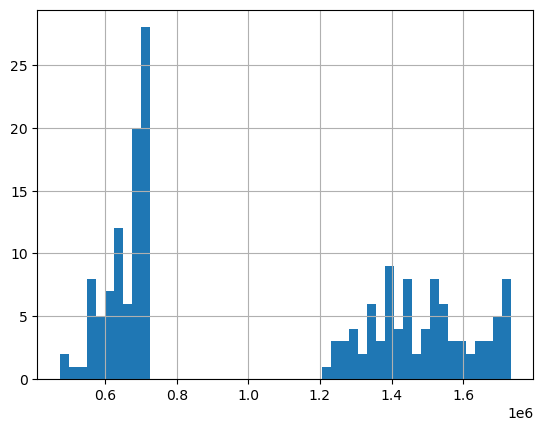

In [13]:
# Добавим столбцы: финансовая прибыль и финансовые убытки
flights_df['financial_losses'] = flights_df.fuel_cost * flights_df.fuel_consumption_per_minute * flights_df.actual_flight_duration
flights_df['financial_profit'] = flights_df['total_tickets_revenue'] - flights_df['financial_losses']

# Переведем столбцы в формат datetime
flights_df.scheduled_departure = pd.to_datetime(flights_df.scheduled_departure)
flights_df.scheduled_arrival = pd.to_datetime(flights_df.scheduled_arrival)
flights_df.actual_departure = pd.to_datetime(flights_df.actual_departure)
flights_df.actual_arrival = pd.to_datetime(flights_df.actual_arrival)

# Добавим столбцы: день недели отправления, час отправления
flights_df['day_of_week'] = flights_df.scheduled_departure.dt.day_name()
flights_df['hour'] = flights_df.scheduled_departure.dt.hour

# Посмотрим гистограмму распределения финансовой прибыли авиакомпании
flights_df['financial_profit'].hist(bins = 50)

Можно заметить, что финансовая прибыль авикомпании отображается на графике в виде двух больших групп. Что это за группы?

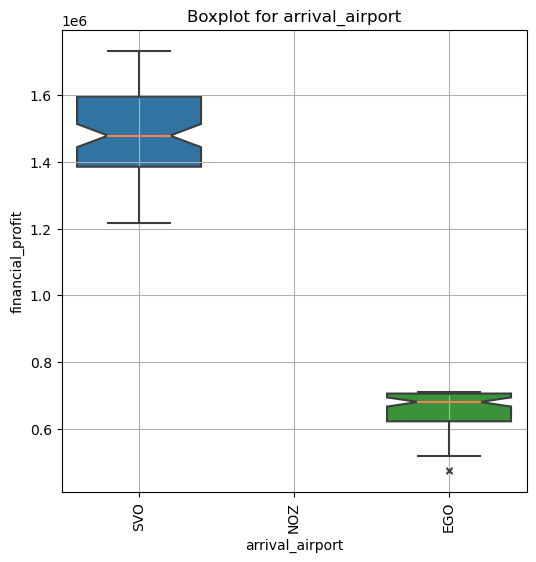

In [89]:
# Построим боксплоты
get_boxplot(flights_df, 'arrival_airport', 'financial_profit')

In [90]:
low_bound_iqr, high_bound_iqr = outliers_iqr(flights_df[flights_df.aircraft_code == 'SU9'].financial_profit)
low_bound_iqr

25-й перцентиль: 622075.6254166666, 
75-й перцентиль: 705329.7308333333, 
IQR: 83254.10541666672, 
Границы выбросов: [497194.46729166654, 830210.8889583334].


497194.46729166654

In [17]:
outliers_iqr(flights_df[flights_df.aircraft_code == '733'].financial_profit)

25-й перцентиль: nan, 
75-й перцентиль: nan, 
IQR: nan, 
Границы выбросов: [nan, nan].


(nan, nan)

In [92]:
# Аэропорт и город назначения самолета SU9
flights_df[flights_df.aircraft_code == 'SU9'][['arrival_airport','arrival_city']].agg(['unique'])

,arrival_airport,arrival_city
unique,[EGO],[Belgorod]


In [19]:
# Аэропорт и город назначения самолета Боинг-733
flights_df[flights_df.aircraft_code == '733'][['arrival_airport','arrival_city']].agg(['unique'])

,arrival_airport,arrival_city
unique,"[SVO, NOZ]","[Moscow, Novokuznetsk]"


- Наблюдается два направления с разными самолетами. Как привести их к относительным величинам?   
- Возьмём относительные потери (относительно полной стоимости билетов).   
- Таким образом мы косвенно учтём, что в цену билетов заложено расстояние до пункта назначения.

In [94]:
# Относительные потери авиакомпании
flights_df['relative_losses'] = flights_df.financial_losses / flights_df.total_tickets_revenue

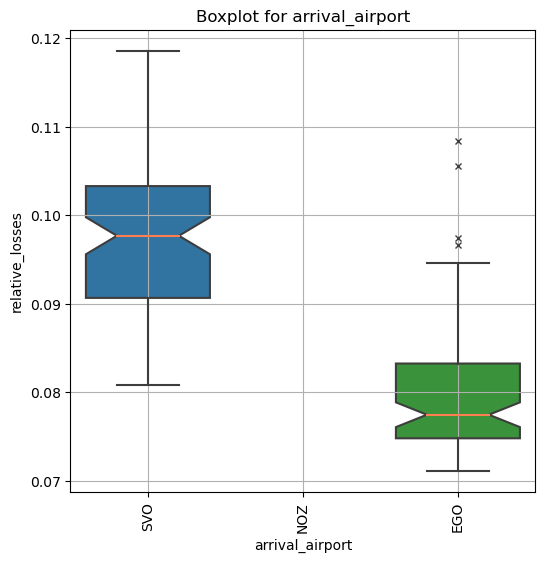

In [95]:
# Посмотрим на распределение относительных потерь по различным направлениям
get_boxplot(flights_df, 'arrival_airport', 'relative_losses')

In [96]:
print(f'Средняя величина относительных потерь на белогородском направлении (Белгород-EGO, Сухой Суперджет-100, код-SU9): {flights_df[flights_df.arrival_airport == "EGO"].relative_losses.mean():.3f}')
print(f'Средняя величина относительных потерь на московском направлении (Москва-SVO, Boeing-733, код-733): {flights_df[flights_df.arrival_airport == "SVO"].relative_losses.mean():.3f}')

round(flights_df[flights_df.arrival_airport == 'EGO'].relative_losses.mean() / flights_df[flights_df.arrival_airport == 'SVO'].relative_losses.mean(), 3)

Средняя величина относительных потерь на белогородском направлении (Белгород-EGO, Сухой Суперджет-100, код-SU9): 0.080
Средняя величина относительных потерь на московском направлении (Москва-SVO, Boeing-733, код-733): 0.098


0.819

In [97]:
flights_df.groupby('aircraft_code' )[['aircraft_code', 'economy_seats_cnt', 'business_seats_cnt', 'all_seats_total_cnt']].head(1)

,aircraft_code,economy_seats_cnt,business_seats_cnt,all_seats_total_cnt
0,733,118,12,130
103,SU9,85,12,97


- На графике видно, что на белогородском направлении (Белгород - EGO, самолёт - SU9) заметны выбросы относительных потерь.   
- В среднем относительные потери при перелёте самолётом Суперджет-100 на 18% ниже, чем относительные потери при эксплуатации Боинга 733. Это вполне логично, т.к. Боинг крупнее и потребляет больше топлива.
- Суперджет содержит 12 мест в салоне бизнес-класса, 85 - в эконом-классе. Боинг содержит больше мест эконом класса.

In [98]:
flights_df_2 = flights_df.copy()
display(flights_df_2.shape)
flights_df_2 = flights_df_2[flights_df_2.arrival_airport != 'NOZ']
display(flights_df_2.shape)

(193, 35)

(180, 35)

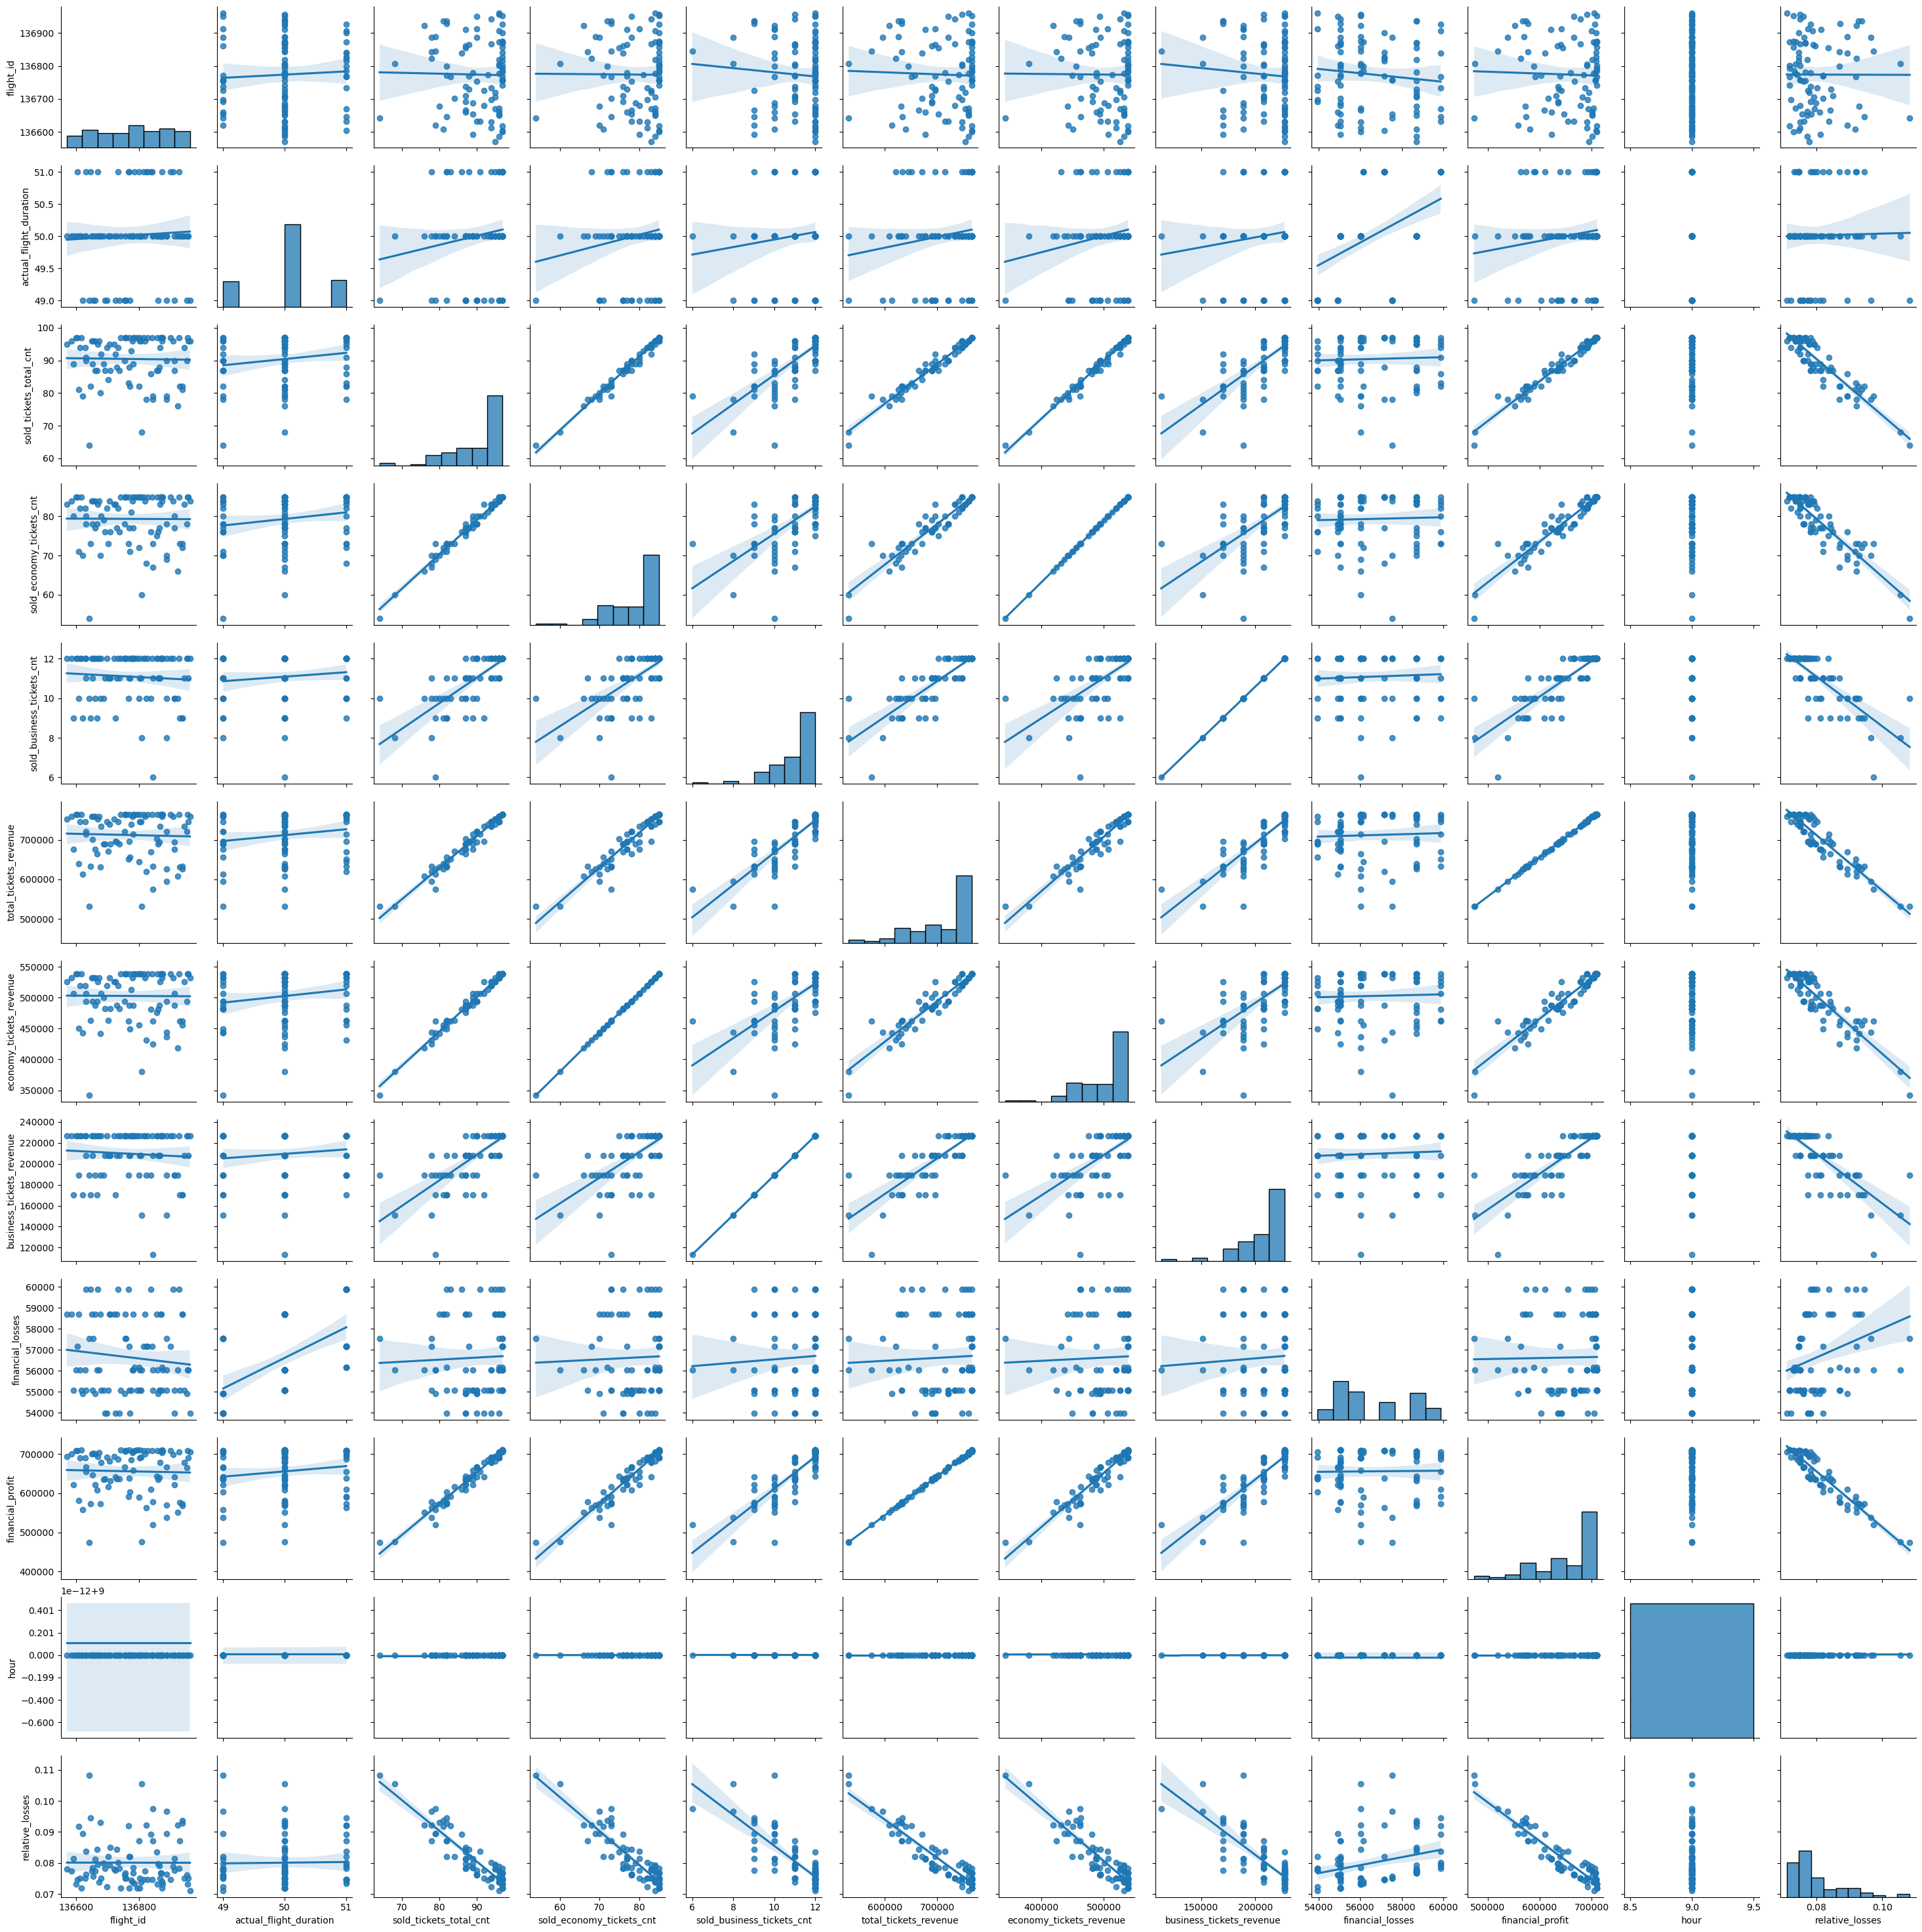

In [139]:
sns.pairplot(flights_df_2[flights_df_2.arrival_airport == 'EGO'][['flight_id', 'flight_no', 'scheduled_departure', 
                                'scheduled_arrival', 'actual_flight_duration', 'aircraft_code', 'sold_tickets_total_cnt', 
                                'sold_economy_tickets_cnt', 'sold_business_tickets_cnt', 'total_tickets_revenue', 
                                'economy_tickets_revenue', 'business_tickets_revenue', 'financial_losses', 
                                'financial_profit', 'day_of_week', 'hour', 'relative_losses']], kind = 'reg')

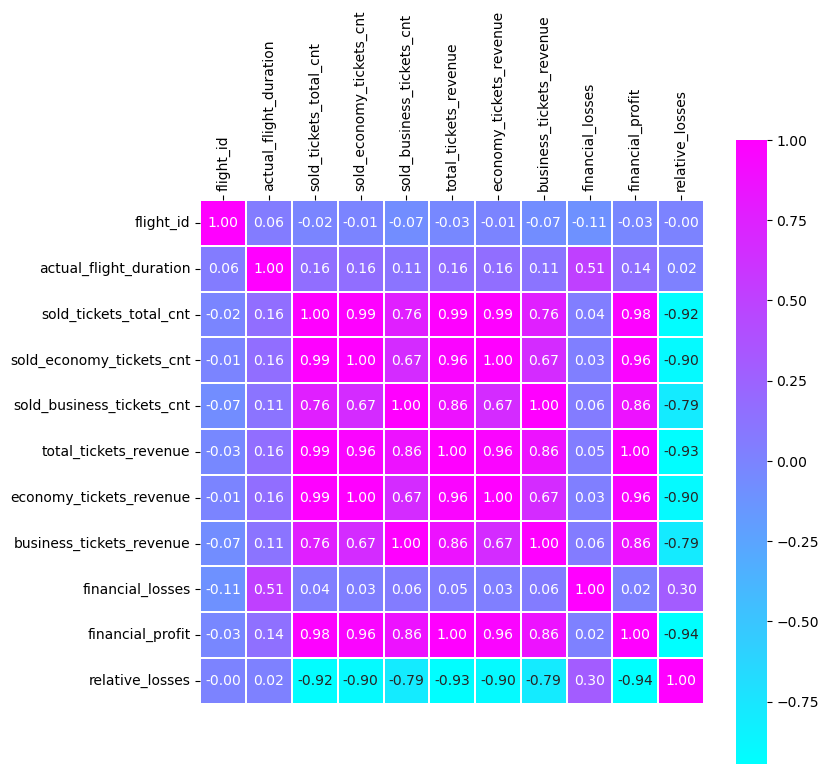

In [146]:
plt.rcParams['figure.figsize'] = (8.5,8)
ax= sns.heatmap(flights_df_2[flights_df_2.arrival_airport == 'EGO'][['flight_id', 'flight_no', 'scheduled_departure', 
                                'scheduled_arrival', 'actual_flight_duration', 'aircraft_code', 'sold_tickets_total_cnt', 
                                'sold_economy_tickets_cnt', 'sold_business_tickets_cnt', 'total_tickets_revenue', 
                                'economy_tickets_revenue', 'business_tickets_revenue', 'financial_losses', 
                                'financial_profit', 'day_of_week', 'relative_losses']].corr(), 
                                square = True, annot = True, fmt = ".2f", linewidths = 0.1, cmap = "cool")
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_tick_params(rotation = 90)
plt.tight_layout()

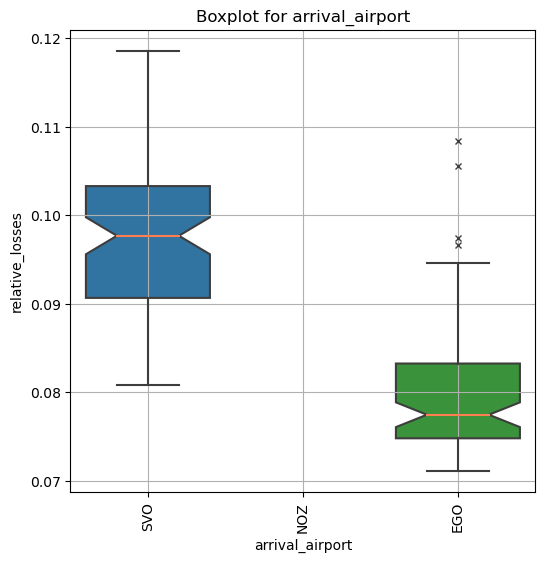

In [100]:
# Посмотрим на распределение относительных потерь
get_boxplot(flights_df, 'arrival_airport', 'relative_losses')

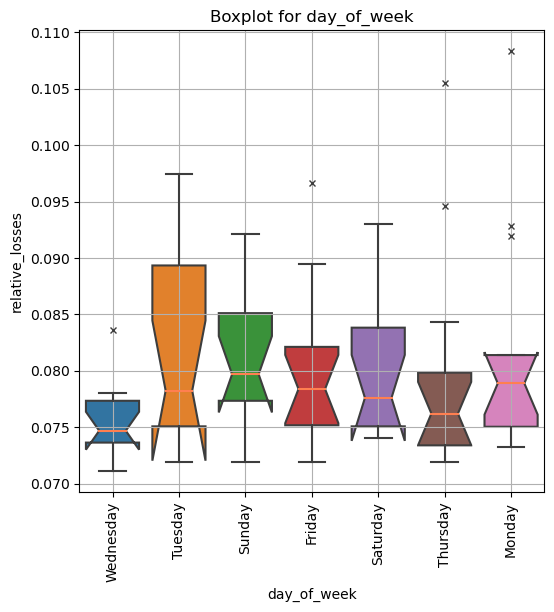

In [101]:
get_boxplot(flights_df[flights_df.aircraft_code == 'SU9'], 'day_of_week', 'relative_losses')

- По графику корреляции можно заметить выраженную зависимость относительных потерь с количеством занятых мест в эконом-классе.  
- Рассмотрим данные, являющиеся выбросами:

In [102]:
low_bound_iqr, high_bound_iqr = outliers_iqr(flights_df[flights_df.aircraft_code == 'SU9'].relative_losses)
flights_df[(flights_df.aircraft_code == 'SU9') & (flights_df.relative_losses > high_bound_iqr)]

25-й перцентиль: 0.07477050812823328, 
75-й перцентиль: 0.08321929930028776, 
IQR: 0.008448791172054479, 
Границы выбросов: [0.062097321370151566, 0.09589248605836947].


,flight_id,flight_no,departure_city,departure_airport,arrival_city,arrival_airport,departure_airport_longitude,departure_airport_latitude,arrival_airport_longitude,arrival_airport_latitude,status,scheduled_departure,scheduled_arrival,actual_departure,actual_arrival,scheduled_flight_duration,actual_flight_duration,aircraft_code,aircraft_model,fuel_consumption_per_minute,fuel_cost,all_seats_total_cnt,sold_tickets_total_cnt,economy_seats_cnt,sold_economy_tickets_cnt,business_seats_cnt,sold_business_tickets_cnt,total_tickets_revenue,economy_tickets_revenue,business_tickets_revenue,financial_losses,financial_profit,day_of_week,hour,relative_losses
115,136642,PG0480,Anapa,AAQ,Belgorod,EGO,37.35,45.00,36.59,50.64,Arrived,2017-01-30 09:25:00+00:00,2017-01-30 10:15:00+00:00,2017-01-30 09:28:00+00:00,2017-01-30 10:17:00+00:00,50.00,49.00,SU9,Sukhoi Superjet-100,28.33,41.44,97,64.00,85,54.00,12,10.00,531000.00,342000.00,189000.00,57525.59,473474.41,Monday,9,0.11
157,136807,PG0480,Anapa,AAQ,Belgorod,EGO,37.35,45.00,36.59,50.64,Arrived,2017-02-23 09:25:00+00:00,2017-02-23 10:15:00+00:00,2017-02-23 09:28:00+00:00,2017-02-23 10:18:00+00:00,50.00,50.00,SU9,Sukhoi Superjet-100,28.33,39.55,97,68.00,85,60.00,12,8.00,531000.00,379800.00,151200.00,56033.42,474966.58,Thursday,9,0.11
165,136844,PG0480,Anapa,AAQ,Belgorod,EGO,37.35,45.00,36.59,50.64,Arrived,2017-02-28 09:25:00+00:00,2017-02-28 10:15:00+00:00,2017-02-28 09:26:00+00:00,2017-02-28 10:16:00+00:00,50.00,50.00,SU9,Sukhoi Superjet-100,28.33,39.55,97,79.00,85,73.00,12,6.00,575100.00,461700.00,113400.00,56033.42,519066.58,Tuesday,9,0.10
177,136887,PG0480,Anapa,AAQ,Belgorod,EGO,37.35,45.00,36.59,50.64,Arrived,2017-01-20 09:25:00+00:00,2017-01-20 10:15:00+00:00,2017-01-20 09:30:00+00:00,2017-01-20 10:19:00+00:00,50.00,49.00,SU9,Sukhoi Superjet-100,28.33,41.44,97,78.00,85,70.00,12,8.00,595200.00,444000.00,151200.00,57525.59,537674.41,Friday,9,0.10


# 4. Выводы

- Согласно проведенному анализу, наиболее невыгодными рейсами являются те рейсы, в которых меньше заполнены места эконом-класса (количество мест: 54-73), и места в бизнес-классе заполнены не полностью (менее 10).  
- Оптимизировать полёты по времени не представляется возможным, т.к. судя по имеющимся данным все самолёты вылетают из Анапы всего в два разных времени.  
- Распределение относительных потерь по дням недели показывает, что наименьшие потери у рейса PG0480 наблюдаются в среду.  
- Рейсы с наибольшими относительными потерями приходятся на будние дни (пн, вт, чт, пт), однако это не означает, что эти дни являются менее прибыльными. Можно исключать некоторые даты: 20 января, 30 января, 23 февраля, 28 февраля.